In [2]:
!pip install numpy pandas matplotlib seaborn scipy scikit-learn statsmodels

In [3]:
import pandas as pd

# Load the dataset (replace 'well_log_iot.csv' with your actual file path)
data = pd.read_csv('/content/well_log_iot.csv')
# Display the first few rows of the dataset
print(data.head())

# Display basic statistics
print(data.describe())

   Depth  Gamma Ray  Resistivity  Sonic  Temperature
0  100.0       60.5          8.7  120.1         82.3
1  100.5       63.2          9.1  119.8         82.5
2  101.0        NaN          9.4  118.9         82.6
3  101.5       65.8          9.6  118.3         82.9
4  102.0       70.1         10.3  117.6         83.1
            Depth   Gamma Ray  Resistivity       Sonic  Temperature
count  113.000000  106.000000   102.000000  110.000000   113.000000
mean   128.000000  166.153774    24.945098   93.784545    99.678761
std     16.382155   55.162141     8.433322   13.161664    10.324956
min    100.000000   60.500000     8.700000   73.700000    82.300000
25%    114.000000  123.575000    18.075000   82.700000    91.200000
50%    128.000000  170.750000    25.350000   92.000000    99.500000
75%    142.000000  212.775000    31.950000  104.175000   108.400000
max    156.000000  252.000000    39.000000  120.100000   117.600000


Missing values per column:
 Depth           0
Gamma Ray       7
Resistivity    11
Sonic           3
Temperature     0
dtype: int64


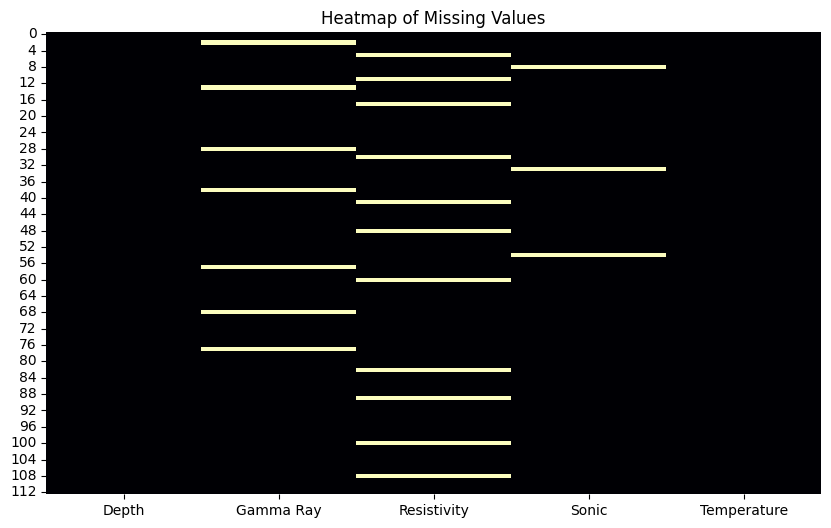

In [4]:
# Checking for missing values
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)

# Visualizing missing data
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(data.isnull(), cbar=False, cmap='magma')
plt.title("Heatmap of Missing Values")
plt.show()

In [5]:
# Option 1: Dropping rows with too many missing values
#data_cleaned = data.dropna(thresh=data.shape[1] - 1)  # Keep rows with at least N-1 non-null values

# Option 2: Fill missing values with the median of each column
#data_cleaned = data.fillna(data.median())

# Option 3: Interpolating missing values (useful for time-series or depth-indexed data)
#data_cleaned = data.interpolate()

# Option 4: KNN Imputation for more advanced imputation
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
data_cleaned = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Check the cleaned dataset
print(data_cleaned.head())

   Depth  Gamma Ray  Resistivity  Sonic  Temperature
0  100.0  60.500000          8.7  120.1         82.3
1  100.5  63.200000          9.1  119.8         82.5
2  101.0  63.166667          9.4  118.9         82.6
3  101.5  65.800000          9.6  118.3         82.9
4  102.0  70.100000         10.3  117.6         83.1


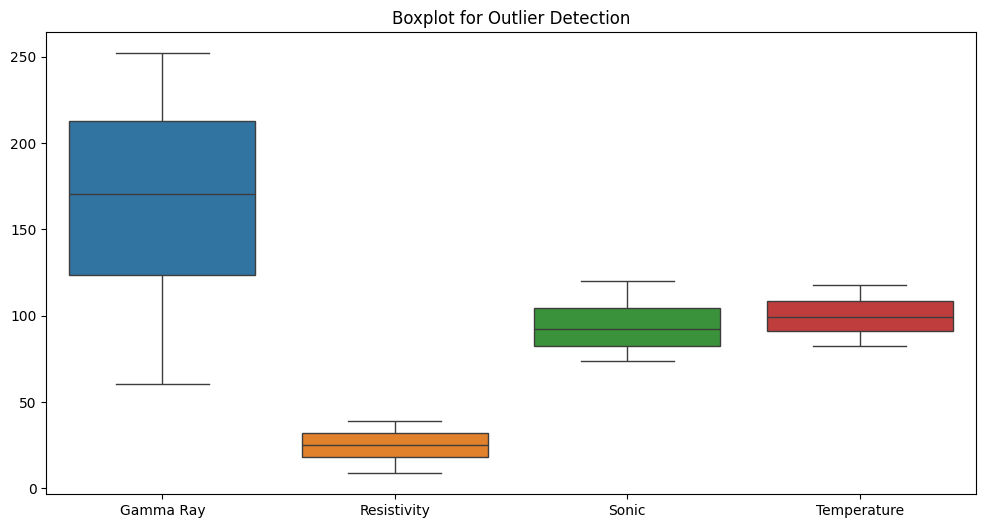

In [6]:
# Visualizing outliers using boxplots
plt.figure(figsize=(12,6))
sns.boxplot(data=data[['Gamma Ray', 'Resistivity', 'Sonic', 'Temperature']])
plt.title('Boxplot for Outlier Detection')
plt.show()

In [9]:
# Z-Score method to detect outliers
from scipy import stats
import numpy as np

#z_scores = np.abs(stats.zscore(data[['Gamma Ray', 'Resistivity', 'Sonic']]))
#outliers_z = np.where(z_scores > 3)
#print("Outliers detected using Z-score at rows:", outliers_z)

# IQR Method to detect outliers
#Q1 = data[['Gamma Ray', 'Resistivity', 'Sonic']].quantile(0.25)
#Q3 = data[['Gamma Ray', 'Resistivity', 'Sonic']].quantile(0.75)
#IQR = Q3 - Q1

#outliers_iqr = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
#print("Outliers detected using IQR method:\n", outliers_iqr.sum())

# IQR Method to detect outliers
Q1 = data[['Gamma Ray', 'Resistivity', 'Sonic']].quantile(0.25)
Q3 = data[['Gamma Ray', 'Resistivity', 'Sonic']].quantile(0.75)
IQR = Q3 - Q1

# Align indices by using broadcasting with .loc
outliers_iqr = (data[['Gamma Ray', 'Resistivity', 'Sonic']] < (Q1 - 1.5 * IQR)) | \
               (data[['Gamma Ray', 'Resistivity', 'Sonic']] > (Q3 + 1.5 * IQR))

print("Outliers detected using IQR method:\n", outliers_iqr.sum())


Outliers detected using IQR method:
 Gamma Ray      0
Resistivity    0
Sonic          0
dtype: int64


In [10]:
# Option 1: Removing outliers (using Z-Score or IQR detection)
#data_cleaned = data[(z_scores < 3).all(axis=1)]

# Option 2: Capping outliers to the 1st and 99th percentile
def cap_outliers(df, column):
    lower = df[column].quantile(0.01)
    upper = df[column].quantile(0.99)
    df[column] = np.clip(df[column], lower, upper)
    return df

for col in ['Gamma Ray', 'Resistivity', 'Sonic']:
    data_cleaned = cap_outliers(data_cleaned, col)

print(data_cleaned.head())

   Depth  Gamma Ray  Resistivity    Sonic  Temperature
0  100.0  63.170667        9.136  119.692         82.3
1  100.5  63.200000        9.136  119.692         82.5
2  101.0  63.170667        9.400  118.900         82.6
3  101.5  65.800000        9.600  118.300         82.9
4  102.0  70.100000       10.300  117.600         83.1


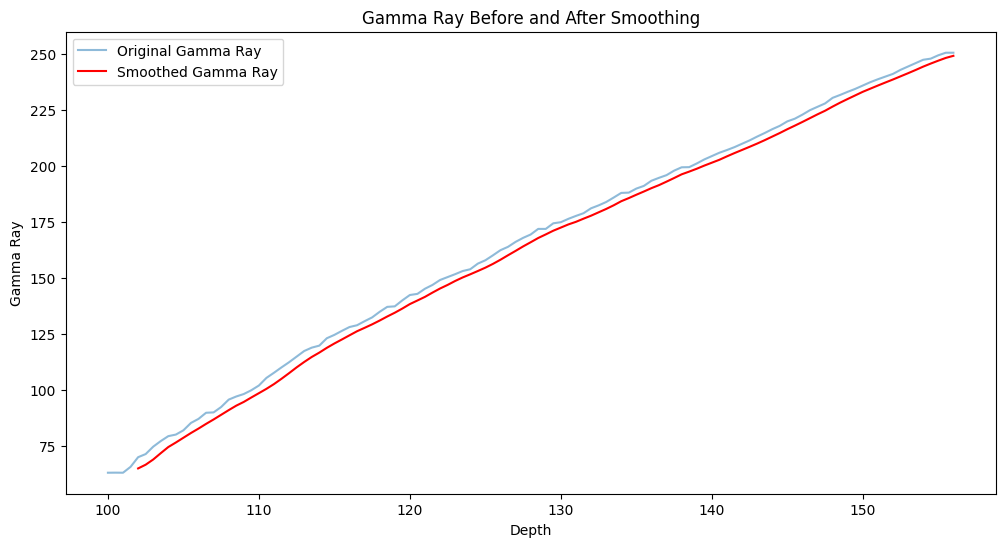

In [11]:
# Apply moving average smoothing with a window of 5
data_cleaned['Gamma Ray (Smoothed)'] = data_cleaned['Gamma Ray'].rolling(window=5).mean()
data_cleaned['Resistivity (Smoothed)'] = data_cleaned['Resistivity'].rolling(window=5).mean()

# Plot the original vs smoothed data
plt.figure(figsize=(12,6))
plt.plot(data_cleaned['Depth'], data_cleaned['Gamma Ray'], label='Original Gamma Ray', alpha=0.5)
plt.plot(data_cleaned['Depth'], data_cleaned['Gamma Ray (Smoothed)'], label='Smoothed Gamma Ray', color='red')
plt.xlabel('Depth')
plt.ylabel('Gamma Ray')
plt.legend()
plt.title('Gamma Ray Before and After Smoothing')
plt.show()

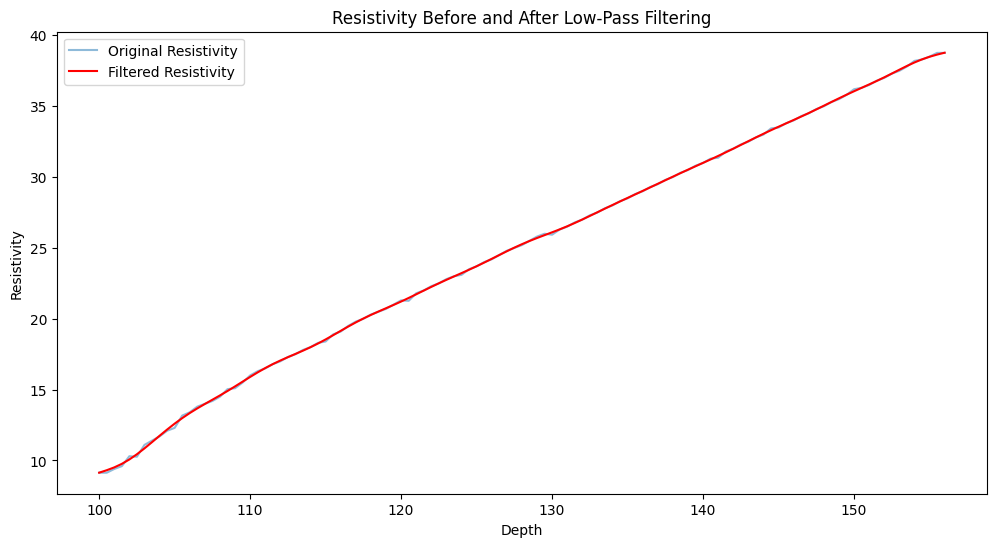

In [12]:
from scipy.signal import butter, filtfilt

# Define a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Apply the low-pass filter
filtered_resistivity = lowpass_filter(data_cleaned['Resistivity'], cutoff=0.1, fs=1.0)

# Plot original vs filtered resistivity
plt.figure(figsize=(12,6))
plt.plot(data_cleaned['Depth'], data_cleaned['Resistivity'], label='Original Resistivity', alpha=0.5)
plt.plot(data_cleaned['Depth'], filtered_resistivity, label='Filtered Resistivity', color='red')
plt.xlabel('Depth')
plt.ylabel('Resistivity')
plt.legend()
plt.title('Resistivity Before and After Low-Pass Filtering')
plt.show()

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Normalize to the range [0, 1]
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_cleaned[['Gamma Ray', 'Resistivity', 'Sonic']]), columns=['Gamma Ray', 'Resistivity', 'Sonic'])

print(data_normalized.head())

   Gamma Ray  Resistivity     Sonic
0   0.000000     0.000000  1.000000
1   0.000156     0.000000  1.000000
2   0.000000     0.008910  0.982653
3   0.014025     0.015661  0.969511
4   0.036962     0.039287  0.954179


In [14]:
from sklearn.preprocessing import StandardScaler

# Standardize to have a mean of 0 and standard deviation of 1
scaler = StandardScaler()
data_standardized = pd.DataFrame(scaler.fit_transform(data_cleaned[['Gamma Ray', 'Resistivity', 'Sonic']]), columns=['Gamma Ray', 'Resistivity', 'Sonic'])

print(data_standardized.head())

   Gamma Ray  Resistivity     Sonic
0  -1.848200    -1.860357  1.960834
1  -1.847664    -1.860357  1.960834
2  -1.848200    -1.829154  1.900307
3  -1.800221    -1.805515  1.854453
4  -1.721757    -1.722779  1.800957


In [15]:
# Creating a simple lithology feature based on Gamma Ray threshold
data_cleaned['Lithology'] = data_cleaned['Gamma Ray'].apply(lambda x: 'Shale' if x > 75 else 'Sand')

print(data_cleaned[['Depth', 'Gamma Ray', 'Lithology']].head())

   Depth  Gamma Ray Lithology
0  100.0  63.170667      Sand
1  100.5  63.200000      Sand
2  101.0  63.170667      Sand
3  101.5  65.800000      Sand
4  102.0  70.100000      Sand


In [16]:
# Simple porosity calculation from the sonic log
data_cleaned['Porosity'] = (data_cleaned['Sonic'] - 50) / 150  # Simplified formula

print(data_cleaned[['Depth', 'Sonic', 'Porosity']].head())

   Depth    Sonic  Porosity
0  100.0  119.692  0.464613
1  100.5  119.692  0.464613
2  101.0  118.900  0.459333
3  101.5  118.300  0.455333
4  102.0  117.600  0.450667


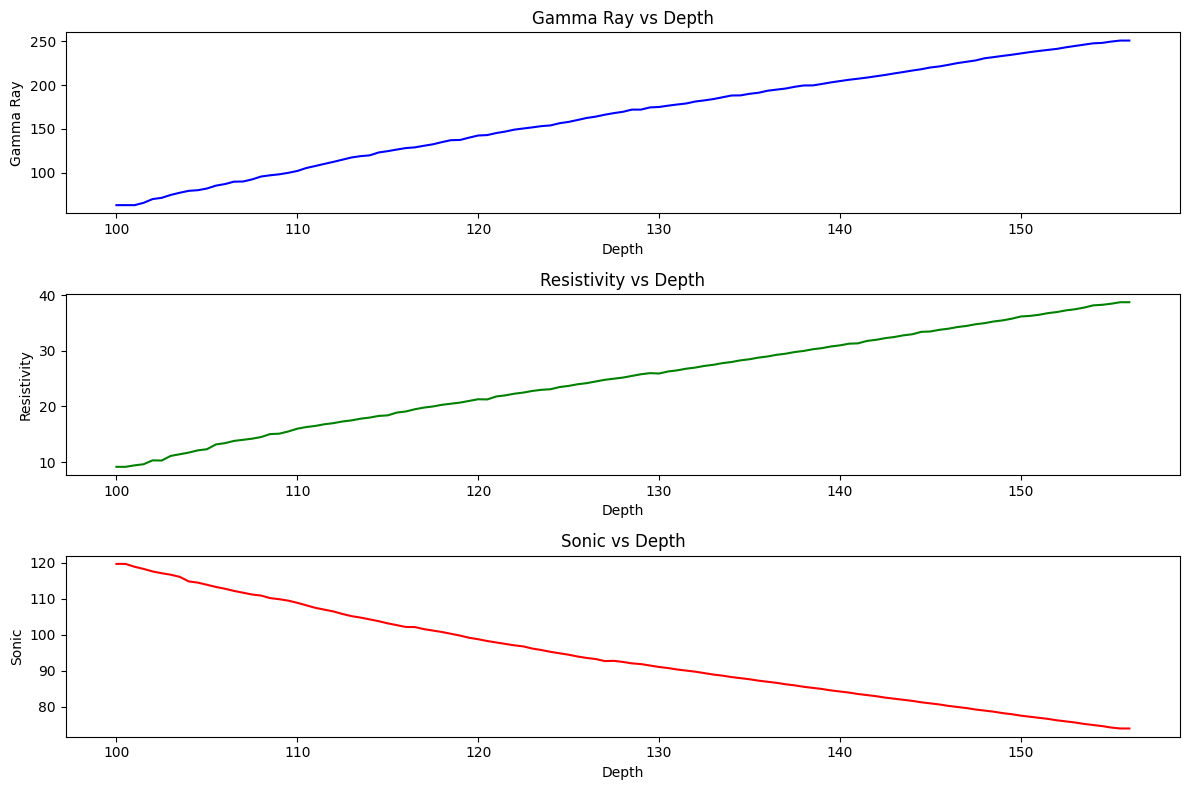

In [17]:
# Plot final cleaned data
plt.figure(figsize=(12,8))

plt.subplot(3, 1, 1)
plt.plot(data_cleaned['Depth'], data_cleaned['Gamma Ray'], label='Gamma Ray', color='blue')
plt.xlabel('Depth')
plt.ylabel('Gamma Ray')
plt.title('Gamma Ray vs Depth')

plt.subplot(3, 1, 2)
plt.plot(data_cleaned['Depth'], data_cleaned['Resistivity'], label='Resistivity', color='green')
plt.xlabel('Depth')
plt.ylabel('Resistivity')
plt.title('Resistivity vs Depth')

plt.subplot(3, 1, 3)
plt.plot(data_cleaned['Depth'], data_cleaned['Sonic'], label='Sonic', color='red')
plt.xlabel('Depth')
plt.ylabel('Sonic')
plt.title('Sonic vs Depth')

plt.tight_layout()
plt.show()